In [2]:
pip install mlstac

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.6 MB/s eta 0:00:00:00:0100:01
  Created wheel for mdutils: filename=mdutils-1.6.0-py3-none-any.whl size=20786 sha256=1ffd6ce70e8fca3af547318c0dd28744ccd76427a6889fc4771e67118f54ec23
  Stored in directory: /root/.cache/pip/wheels/fc/06/00/0b1f3d0bec86776c2330c61c21a57e8f65798df995ac1591ca
Successfully built mdutils
Note: you may need to restart the kernel to use updated packages.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Validation - Epoch 20/20: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s, loss=0.9114]
<ipython-input-2-771b2609f6f7>:234: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly 

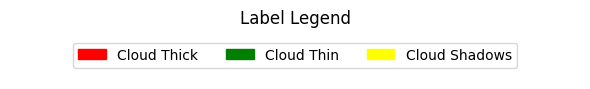

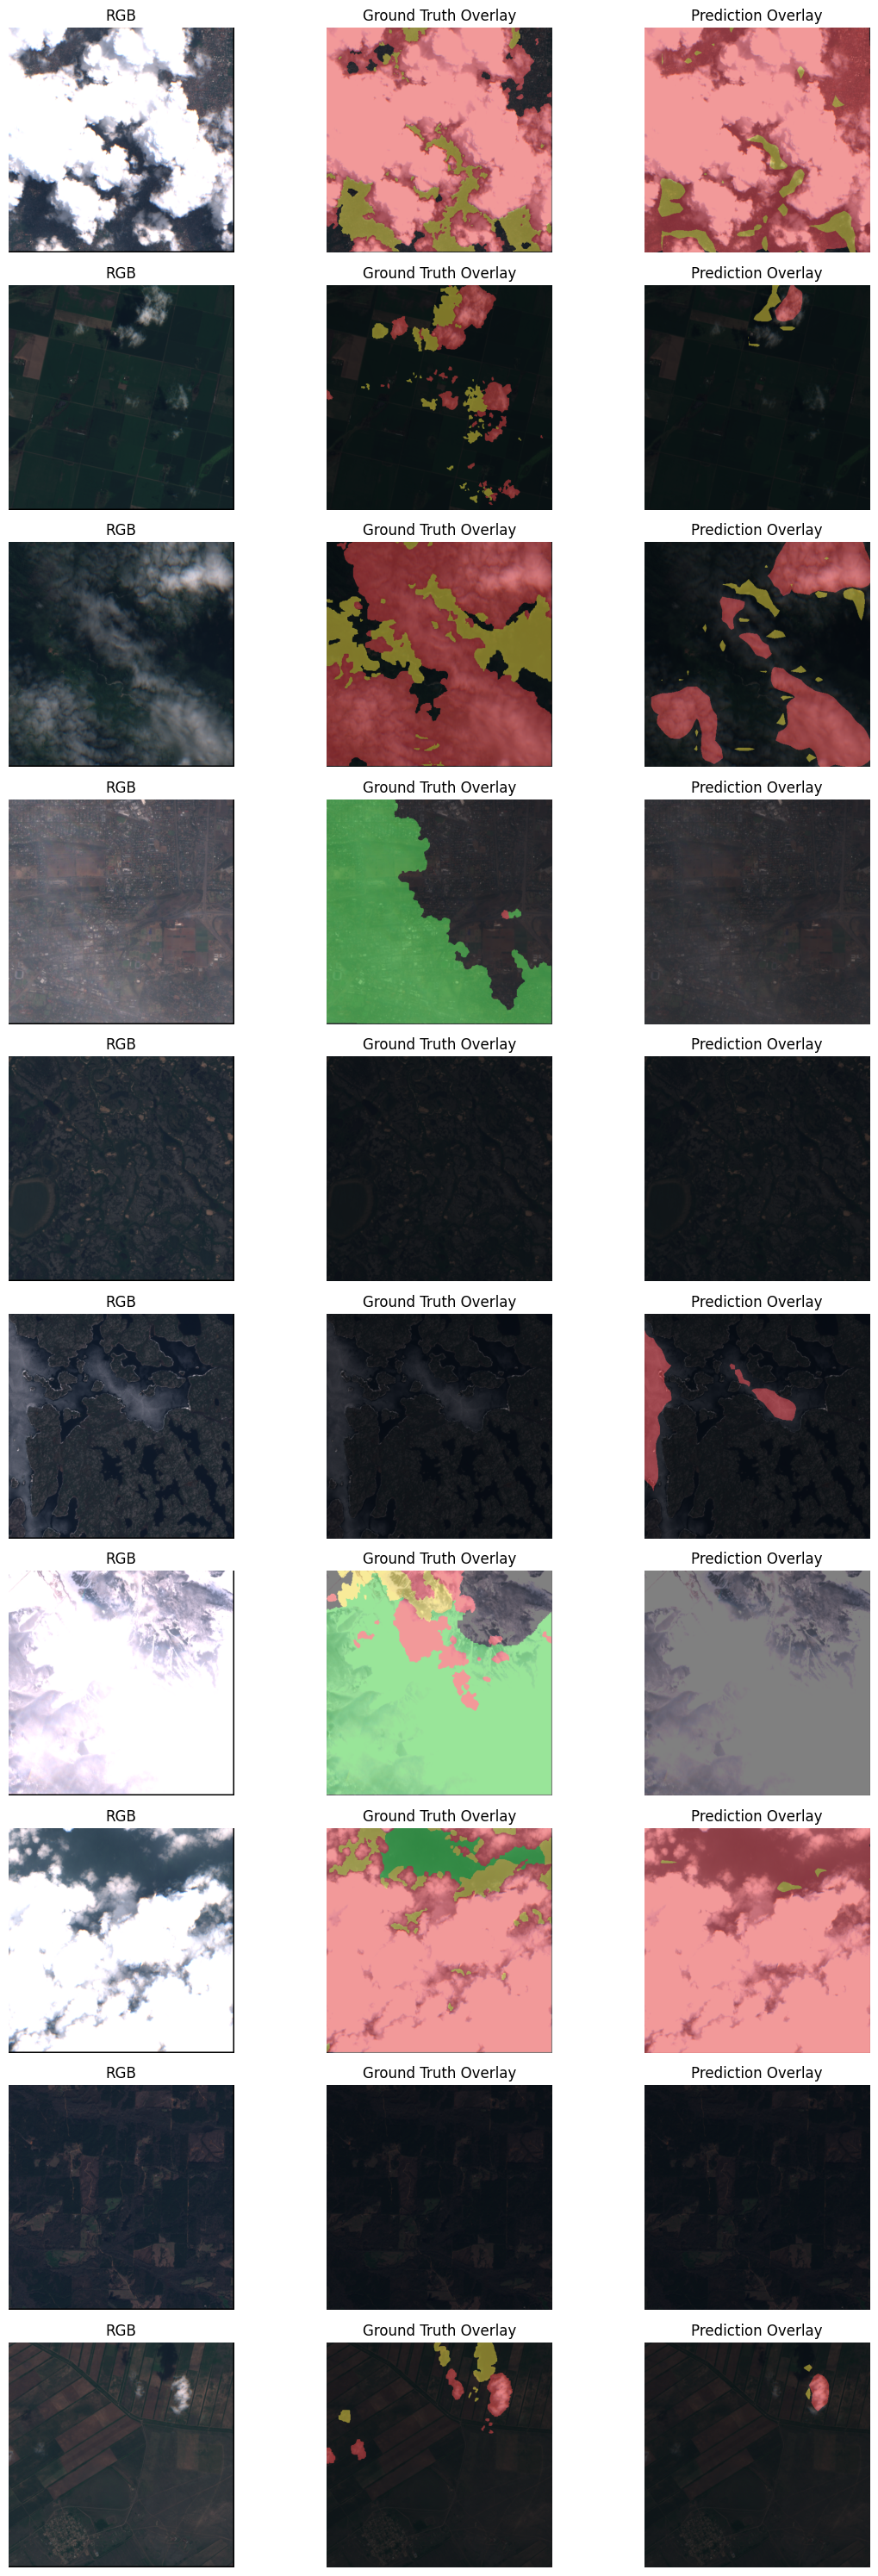

In [2]:
# segmentation_training_pipeline.py

import os, pickle, random, logging, numpy as np, cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Hyperparameters and settings
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4
EPOCHS = 20
TRAIN_PERCENTAGE = 1
LEARNING_RATE = 1e-4

IMG_H, IMG_W = 509, 509
IN_CHANNELS = 3
EMBED_DIM = 256
PATCH_SIZE = 19
PAD = 5

NUM_TRANS_LAYERS = 4
NUM_HEADS = 8
GAT_HIDDEN = 512
GAT_LAYERS = 2
D_SKIP = EMBED_DIM
D_GAT_OUT = GAT_HIDDEN
NUM_CLASSES = 4

TRAIN_PATH = '/kaggle/input/clouddata/train_split.pkl'
VAL_PATH   = '/kaggle/input/clouddata/val_split.pkl'
TEST_PATH  = '/kaggle/input/clouddata/test_split.pkl'

# Model Modules
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=IN_CHANNELS, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, padding=PAD):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, padding=padding)
    def forward(self, x):
        x = self.proj(x)
        B, C, H, W = x.shape
        return x.flatten(2).transpose(1, 2)

class ViTBackbone(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_layers=NUM_TRANS_LAYERS, num_heads=NUM_HEADS):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    def forward(self, x):
        return self.encoder(x.transpose(0,1)).transpose(0,1)

class Block1and2(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = PatchEmbedding()
        self.transformer = ViTBackbone()
    def forward(self, x):
        features_intermediate = self.patch_embed(x)
        features_vit = self.transformer(features_intermediate)
        return features_vit, features_intermediate

def build_graph(features):
    adjacency_matrix = torch.matmul(features, features.transpose(1,2))
    return features, adjacency_matrix

class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, alpha=0.2):
        super().__init__()
        self.W = nn.Linear(in_features, out_features, bias=False)
        self.a = nn.Linear(2 * out_features, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU(alpha)
        self.dropout = nn.Dropout(dropout)
    def forward(self, h, adj):
        B, N, _ = h.shape
        Wh = self.W(h)
        Wh_i = Wh.unsqueeze(2).expand(B, N, N, -1)
        Wh_j = Wh.unsqueeze(1).expand(B, N, N, -1)
        e = self.leakyrelu(self.a(torch.cat([Wh_i, Wh_j], dim=-1))).squeeze(-1)
        attention = torch.softmax(e, dim=-1)
        attention = self.dropout(attention)
        h_prime = torch.matmul(attention, Wh)
        return torch.relu(h_prime)

class GAT(nn.Module):
    def __init__(self, in_features, hidden_features, num_layers=GAT_LAYERS, dropout=0.1, alpha=0.2):
        super().__init__()
        layers = [GATLayer(in_features, hidden_features, dropout, alpha) if i==0 
                  else GATLayer(hidden_features, hidden_features, dropout, alpha) 
                  for i in range(num_layers)]
        self.layers = nn.ModuleList(layers)
    def forward(self, h, adj):
        for layer in self.layers:
            h = layer(h, adj)
        return h

class Decoder(nn.Module):
    def __init__(self, in_channels, num_classes=NUM_CLASSES):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.upsample = nn.Upsample(size=(IMG_H, IMG_W), mode='bilinear', align_corners=True)
        self.conv_out = nn.Conv2d(in_channels, num_classes, kernel_size=1)
    def forward(self, x, skip):
        x = torch.cat([x, skip], dim=1)
        x = self.relu(self.conv1(x))
        x = self.upsample(x)
        return self.conv_out(x)

class SegmentationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.block12 = Block1and2()
        self.gat = GAT(in_features=EMBED_DIM, hidden_features=GAT_HIDDEN)
        self.decoder = Decoder(in_channels=GAT_HIDDEN + EMBED_DIM)
    def forward(self, x):
        features_vit, features_intermediate = self.block12(x)
        graph_nodes, adj = build_graph(features_vit)
        features_gat = self.gat(graph_nodes, adj)
        B = features_gat.shape[0]
        grid_dim = 27
        features_gat_grid = features_gat.transpose(1,2).view(B, GAT_HIDDEN, grid_dim, grid_dim)
        skip_grid = features_intermediate.transpose(1,2).view(B, EMBED_DIM, grid_dim, grid_dim)
        return self.decoder(features_gat_grid, skip_grid)

# Dataset and DataLoader
class CloudDataset(Dataset):
    def __init__(self, pickle_file, transform=None):
        with open(pickle_file, "rb") as f:
            self.data = pickle.load(f)
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        sample = self.data[idx]
        rgb = np.moveaxis(sample[[3,2,1]], 0, -1)
        rgb = rgb.astype(np.float32) / 5000.0
        rgb = torch.tensor(rgb.transpose(2,0,1))
        label = sample[13]
        label = cv2.resize(label, (IMG_W, IMG_H), interpolation=cv2.INTER_NEAREST)
        label = torch.tensor(label.astype(np.int64))
        return rgb, label

def load_data(train_path, val_path, test_path, train_percentage=1.0):
    train_dataset = CloudDataset(train_path)
    val_dataset = CloudDataset(val_path)
    test_dataset = CloudDataset(test_path)
    if train_percentage < 1.0:
        n_train = int(len(train_dataset) * train_percentage)
        indices = random.sample(range(len(train_dataset)), n_train)
        train_dataset.data = [train_dataset.data[i] for i in indices]
    return train_dataset, val_dataset, test_dataset

train_ds, val_ds, test_ds = load_data(TRAIN_PATH, VAL_PATH, TEST_PATH, TRAIN_PERCENTAGE)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

logger.info("Datasets: train=%d, val=%d, test=%d", len(train_ds), len(val_ds), len(test_ds))

# Model, Optimizer, and Loss Function
model = SegmentationModel().to(DEVICE)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Training Loop with Mixed Precision and Persistent TQDM
scaler = torch.amp.GradScaler(device=DEVICE)

def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch, total_epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(dataloader, desc=f"Training - Epoch {epoch}/{total_epochs}", leave=True)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    epoch_loss = running_loss / len(dataloader.dataset)
    logger.info("Epoch %d/%d - Training Loss: %.4f", epoch, total_epochs, epoch_loss)
    return epoch_loss

def validate(model, dataloader, criterion, device, epoch, total_epochs):
    model.eval()
    running_loss = 0.0
    pbar = tqdm(dataloader, desc=f"Validation - Epoch {epoch}/{total_epochs}", leave=True)
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            pbar.set_postfix(loss=f"{loss.item():.4f}")
    epoch_loss = running_loss / len(dataloader.dataset)
    logger.info("Epoch %d/%d - Validation Loss: %.4f", epoch, total_epochs, epoch_loss)
    return epoch_loss

best_val_loss = float('inf')
best_model_path = "best_segmentation_model.pth"

for epoch in range(1, EPOCHS+1):
    logger.info("Starting Epoch %d/%d", epoch, EPOCHS)
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE, epoch, EPOCHS)
    val_loss = validate(model, val_loader, criterion, DEVICE, epoch, EPOCHS)
    logger.info("Epoch %d/%d - Train Loss: %.4f  Val Loss: %.4f", epoch, EPOCHS, train_loss, val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        logger.info("Saved best model at Epoch %d with Val Loss: %.4f", epoch, val_loss)

# Load the best model for inference
model.load_state_dict(torch.load(best_model_path))
logger.info("Loaded best model from %s", best_model_path)

# Plotting: Label Legend and Overlay Predictions
import matplotlib.patches as mpatches

def plot_label_legend():
    legend_patches = [
        mpatches.Patch(color='red', label='Cloud Thick'),
        mpatches.Patch(color='green', label='Cloud Thin'),
        mpatches.Patch(color='yellow', label='Cloud Shadows')
    ]
    fig, ax = plt.subplots(figsize=(6, 1))
    ax.axis("off")
    ax.legend(handles=legend_patches, loc='center', ncol=3)
    ax.set_title("Label Legend", fontsize=12)
    plt.tight_layout()
    plt.show()

plot_label_legend()

def plot_overlays(model, dataloader, device, num_samples=10, overlay_alpha=0.5):
    samples = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            imgs = images.cpu().numpy()
            for i in range(len(imgs)):
                samples.append((imgs[i], labels[i].numpy(), preds[i]))
                if len(samples) >= num_samples:
                    break
            if len(samples) >= num_samples:
                break

    overlay_colors = {
        1: np.array([0.9, 0.2, 0.2]),   # Red for Cloud Thick
        2: np.array([0.2, 0.8, 0.2]),   # Green for Cloud Thin
        3: np.array([0.95, 0.85, 0.2])  # Yellow for Cloud Shadows
    }

    fig, axs = plt.subplots(num_samples, 3, figsize=(12, 3 * num_samples))
    for i, (img, gt, pred) in enumerate(samples):
        rgb = np.moveaxis(img, 0, -1)
        if gt.shape != pred.shape:
            gt = cv2.resize(gt.astype(np.uint8), (pred.shape[1], pred.shape[0]), interpolation=cv2.INTER_NEAREST)
        overlay_gt = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.float32)
        overlay_pred = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.float32)
        for cls in [1, 2, 3]:
            mask_gt = (gt == cls)
            overlay_gt[mask_gt] = overlay_colors[cls]
            mask_pred = (pred == cls)
            overlay_pred[mask_pred] = overlay_colors[cls]
        axs[i, 0].imshow(rgb)
        axs[i, 0].set_title("RGB")
        axs[i, 0].axis("off")
        axs[i, 1].imshow(rgb)
        axs[i, 1].imshow(overlay_gt, alpha=overlay_alpha)
        axs[i, 1].set_title("Ground Truth Overlay")
        axs[i, 1].axis("off")
        axs[i, 2].imshow(rgb)
        axs[i, 2].imshow(overlay_pred, alpha=overlay_alpha)
        axs[i, 2].set_title("Prediction Overlay")
        axs[i, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

plot_overlays(model, val_loader, DEVICE, num_samples=10)
